데이터 분석 공부를 제대로 시작한지 이제 한달 정도된 데이터 분석 초보자입니다.

다른 분들이 올려주신 글을 참고하여 분석을 시행했습니다.

저와 같이 데이터 분석을 처음 접하시는 분들에게 대략적인 데이터 분석의 방향을 읽을 수 있는 좋은 참고용 코드가 되었으면 좋겠습니다.

끝으로 제 코드에 대한 데이터 분석 고수 분들의 많은 조언과 가르침 주시면 감사하겠습니다.

그리고 데이터 분석의 공부 방향에 대해서도 알려주시면 정말 감사하겠습니다.

# 분석
1. 각 feature들이 target인 info에 어떠한 영향을 주는지 알아봄
 - date의 경우 년 월 일로 나눠서 시각화
 - title의 경우 각 내용이 겹치는지와 문자의 길이를 바탕으로 시각화
 - content의 경우 각 내용이 겹치는지와 문자의 길이를 바탕으로 시각화
 - ord의 경우 숫자의 변화에 따른 target의 변화를 시각화
2. 분석 결과를 바탕으로 keras를 활용해 딥러닝 모델을 만들어 학습
3. 예측

In [ ]:
# 패키지 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 경고메세지를 무시해줌
import warnings
warnings.filterwarnings("ignore")

# 데이터 확인

In [ ]:
# 데이터 불러오기
train = pd.read_csv('/content/drive/MyDrive/Project/AI야, 진짜 뉴스를 찾아줘!/open/news_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Project/AI야, 진짜 뉴스를 찾아줘!/open/news_test.csv')
submission = pd.read_csv('/content/drive/MyDrive/Project/AI야, 진짜 뉴스를 찾아줘!/open/sample_submission.csv')

In [ ]:
train.head()

,n_id,date,title,content,ord,info
0,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,[이데일리 MARKETPOINT]15:32 현재 코스닥 기관 678억 순매도,1,0
1,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"""실적기반"" 저가에 매집해야 할 8월 급등유망주 TOP 5 전격공개",2,1
2,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,"하이스탁론, 선취수수료 없는 월 0.4% 최저금리 상품 출시",3,1
3,NEWS02580,20200605,[마감]코스닥 기관 678억 순매도,종합 경제정보 미디어 이데일리 - 무단전재 & 재배포 금지,4,0
4,NEWS09727,20200626,"롯데·공영 등 7개 TV 홈쇼핑들, 동행세일 동참",전국적인 소비 붐 조성에 기여할 예정,1,0


In [ ]:
test.head()

,n_id,date,title,content,ord,id
0,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",마이크로 LED TV 장비 양산 돌입- 전방업체 투자 확대로 본업도 호조연일 '신고가',1,NEWS00237_1
1,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",[이데일리 김대웅 기자] 반도체 장비 업체 코세스(089890)의 기술력이 마이크로...,2,NEWS00237_2
2,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",최근 대형 업체들과 거래를 맺고 관련 장비들의 양산에 돌입하면서 주가도 연일 신고가...,3,NEWS00237_3
3,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대",TV를 필두로 올해부터 마이크로 LED의 시대가 본격적으로 개화할 것으로 예상되면서...,4,NEWS00237_4
4,NEWS00237,20200118,"[주목!e스몰캡]코세스, 마이크로LED 시장 개화 최대수혜 기대","코세스는 반도체 장비를 제조, 판매하는 업체로 지난 2006년 11월 코스닥 시장에...",5,NEWS00237_5


In [ ]:
submission.head()

,id,info
0,NEWS00237_1,0
1,NEWS00237_2,0
2,NEWS00237_3,0
3,NEWS00237_4,0
4,NEWS00237_5,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118745 entries, 0 to 118744
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   n_id     118745 non-null  object
 1   date     118745 non-null  int64 
 2   title    118745 non-null  object
 3   content  118745 non-null  object
 4   ord      118745 non-null  int64 
 5   info     118745 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 5.4+ MB


# EDA

## date

info에 영향을 주는 date관련 변수를 찾지 못함
- 따라서 현재까지 분석 결과 date가 유의미한 차이를 가져다 주는 변수는 아님

In [ ]:
train['date'] = train['date'].apply(lambda x : str(x))

In [ ]:
train['date'] = pd.to_datetime(train['date'], format='%Y%m%d')

In [ ]:
train['date_year'] = train['date'].dt.year # 년도
train['date_month'] = train['date'].dt.month # 월
train['date_day'] = train['date'].dt.day # 일

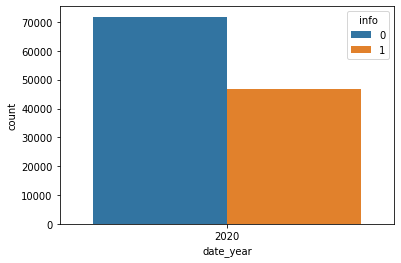

In [ ]:
sns.countplot(data = train, x='date_year', hue='info')

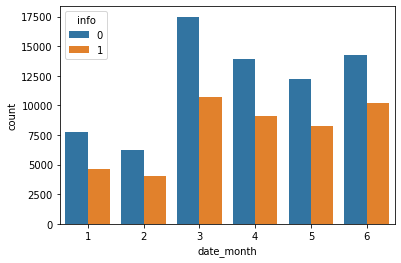

In [ ]:
sns.countplot(data = train, x='date_month', hue='info')

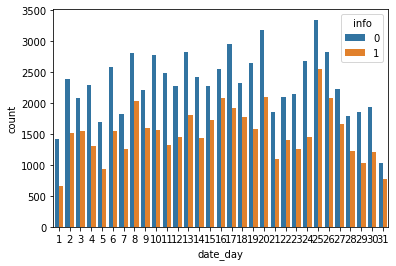

In [ ]:
sns.countplot(data = train, x='date_day', hue='info')

## title

가짜 뉴스의 타이틀이 진짜 뉴스의 타이틀보다 상대적으로 더 적음 하지만 가짜와 진짜 중에 겹치는 제목이 생각보다 매우 많음

- 따라서 현재까지 분석 결과로는 title이 유의미한 차이를 가져다 주는 변수는 아님

In [ ]:
# 가짜 뉴스의 내용과 진짜 뉴스는 서로 겹치는 제목이 매우 많음
len(set(train[train['info'] == 1]['title'].unique()) & set(train[train['info'] == 0]['title'].unique())) / train['title'].nunique()

0.9368450082735797

In [ ]:
train[train['info'] == 1][['title']].nunique() / train[['title']].nunique()

title    0.937397
dtype: float64

In [ ]:
train[train['info'] == 0][['title']].nunique() / train[['title']].nunique()

title    0.999448
dtype: float64

In [ ]:
train['title_len'] = train['title'].apply(lambda x : len(x))

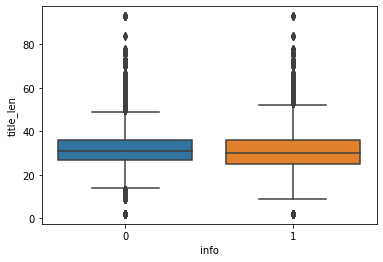

In [ ]:
sns.boxplot(data = train, y='title_len', x='info')

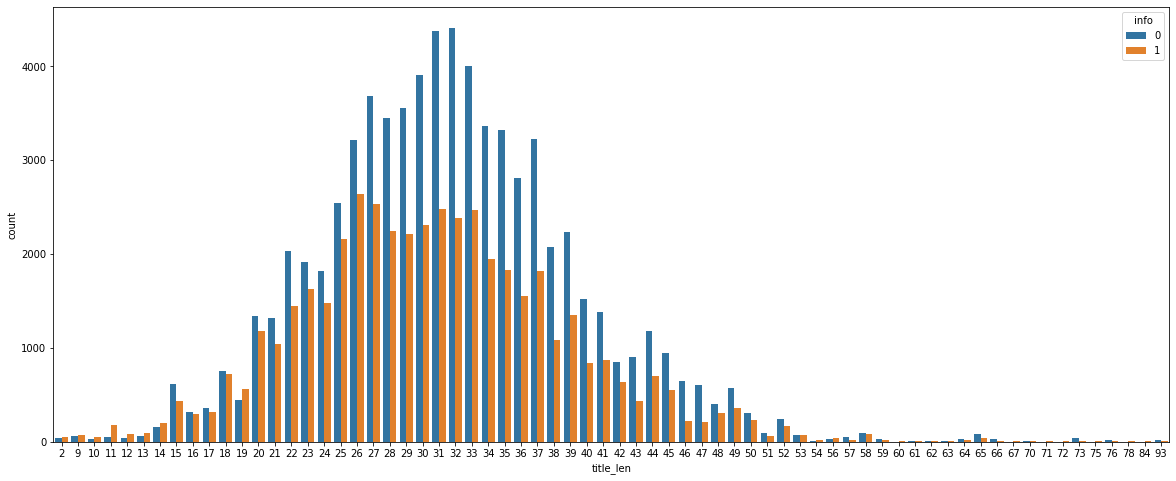

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(data = train, x='title_len', hue='info')

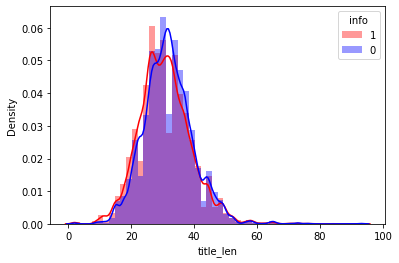

In [ ]:
sns.distplot(train[train['info'] == 1]['title_len'], color='red', label='1')
sns.distplot(train[train['info'] == 0]['title_len'], color='blue', label='0')
plt.legend(title='info')

## content

- content의 길이가 짧을 수록 가짜 뉴스일 확률은 높아진다고 할 수 있음
- 가짜 뉴스의 content와 진짜 뉴스의 content는 완전히 다르다는 것을 알 수 있음

따라서 현재까지 분석결과 content는 유의미한 차이를 가져다 주는 변수인 것으로 확인됨

In [ ]:
# 가짜 뉴스의 내용과 진짜 뉴스는 서로 겹치는 내용이 매우 적음
len(set(train[train['info'] == 1]['content'].unique()) & set(train[train['info'] == 0]['content'].unique())) / train['content'].nunique()

6.498992656138298e-05

In [ ]:
train[train['info'] == 1][['content']].nunique() / train[['content']].nunique()

content    0.125517
dtype: float64

In [ ]:
train[train['info'] == 0][['content']].nunique() / train[['content']].nunique()

content    0.874548
dtype: float64

In [ ]:
train['content_len'] = train['content'].apply(lambda x : len(x))

In [ ]:
Q1 = train[train['info'] == 1].describe(include='all')['content_len']['25%']
Q3 = train[train['info'] == 1].describe(include='all')['content_len']['75%']
IQR = Q3 - Q1
maximum = Q3 + 1.5*IQR
maximum

57.0

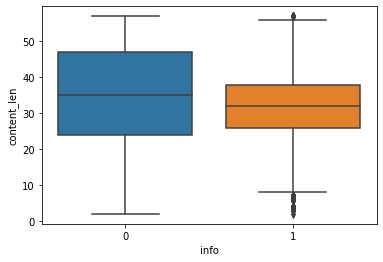

In [ ]:
# 이상치가 시각화에 영향을 줌에 따라 info가 1인 content_len의 IQR범위를 활용해서 이상치를 어느 정도 제거 후 그래프를 그림
sns.boxplot(data = train[train['content_len'] <= maximum], y='content_len', x='info')

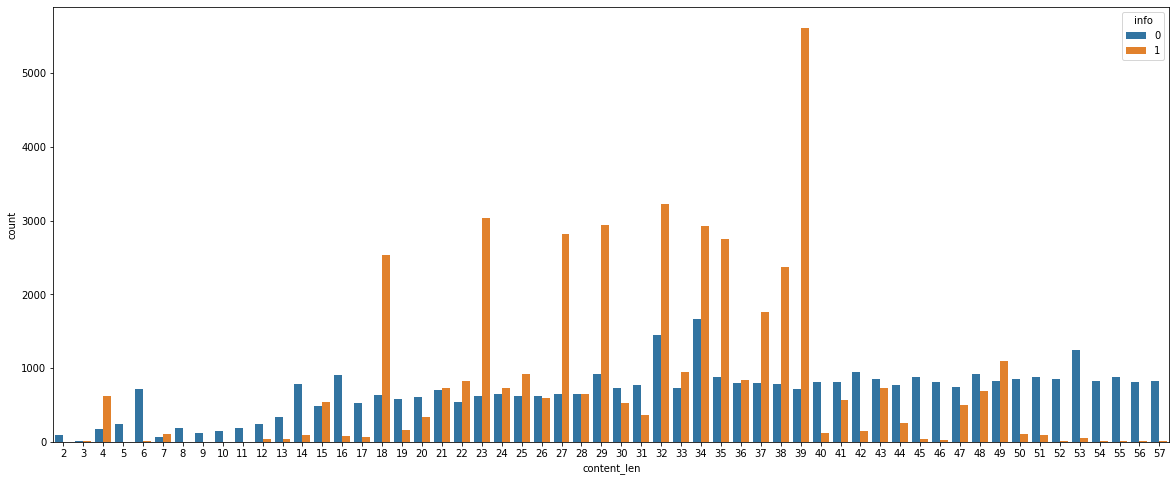

In [ ]:
plt.figure(figsize=(20,8))
sns.countplot(data = train[train['content_len'] <= maximum], x='content_len', hue='info')

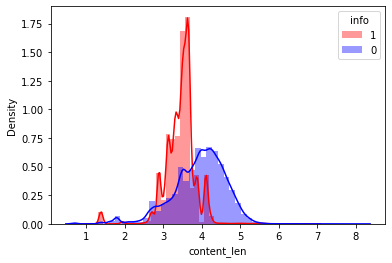

In [ ]:
sns.distplot(np.log(train[train['info'] == 1]['content_len']), color='red', label='1')
sns.distplot(np.log(train[train['info'] == 0]['content_len']), color='blue', label='0')
plt.legend(title='info')

### 명사만을 활용한 간단한 자연어 처리

In [ ]:
pip install konlpy

In [ ]:
from konlpy.tag import Okt

In [ ]:
Okt = Okt()

In [ ]:
from tqdm import tqdm

new_content=[]
for word in tqdm(train['content'].values):
  new_content.append(' '.join(Okt.nouns(word)))
train['new_content'] = new_content

In [ ]:
from tqdm import tqdm

new_content=[]
for word in tqdm(test['content'].values):
  new_content.append(' '.join(Okt.nouns(word)))
test['new_content'] = new_content

100%|██████████| 142565/142565 [06:28<00:00, 367.29it/s]


## ord

- ord가 작다며 진짜 뉴스일 확률이 높아지는 경향을 보임
- 하지만 ord가 커질 수록 가짜 뉴스와 진짜 뉴스의 비율이 비슷해짐

따라서 현재까지 분석 결과 ord가 유의미한 차이를 가져다 주기는 하지만 유의미한 차이를 가져다주는 변수인지는 조금 더 분석을 해봐야 할 듯

In [ ]:
train.describe(include='all')['ord']

count     118745.000000
unique              NaN
top                 NaN
freq                NaN
first               NaN
last                NaN
mean          39.125614
std           45.138605
min            1.000000
25%            9.000000
50%           21.000000
75%           56.000000
max          396.000000
Name: ord, dtype: float64

In [ ]:
train[train['info'] == 1].describe(include='all')['ord']

count     46932.000000
unique             NaN
top                NaN
freq               NaN
first              NaN
last               NaN
mean         46.052416
std          43.153748
min           1.000000
25%          15.000000
50%          33.000000
75%          65.000000
max         396.000000
Name: ord, dtype: float64

In [ ]:
train[train['info'] == 0].describe(include='all')['ord']

count     71813.000000
unique             NaN
top                NaN
freq               NaN
first              NaN
last               NaN
mean         34.598736
std          45.827948
min           1.000000
25%           6.000000
50%          15.000000
75%          48.000000
max         374.000000
Name: ord, dtype: float64

In [ ]:
# 
Q1 = train[train['info'] == 1].describe(include='all')['ord']['25%']
Q3 = train[train['info'] == 1].describe(include='all')['ord']['75%']
IQR = Q3 - Q1
maximum = Q3 + 1.5*IQR
maximum

140.0

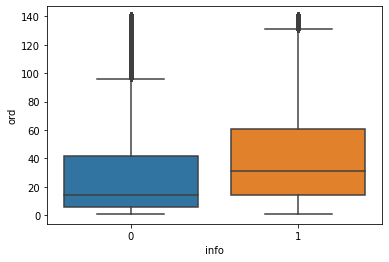

In [ ]:
sns.boxplot(data = train[train['ord'] <= maximum], y='ord', x='info')

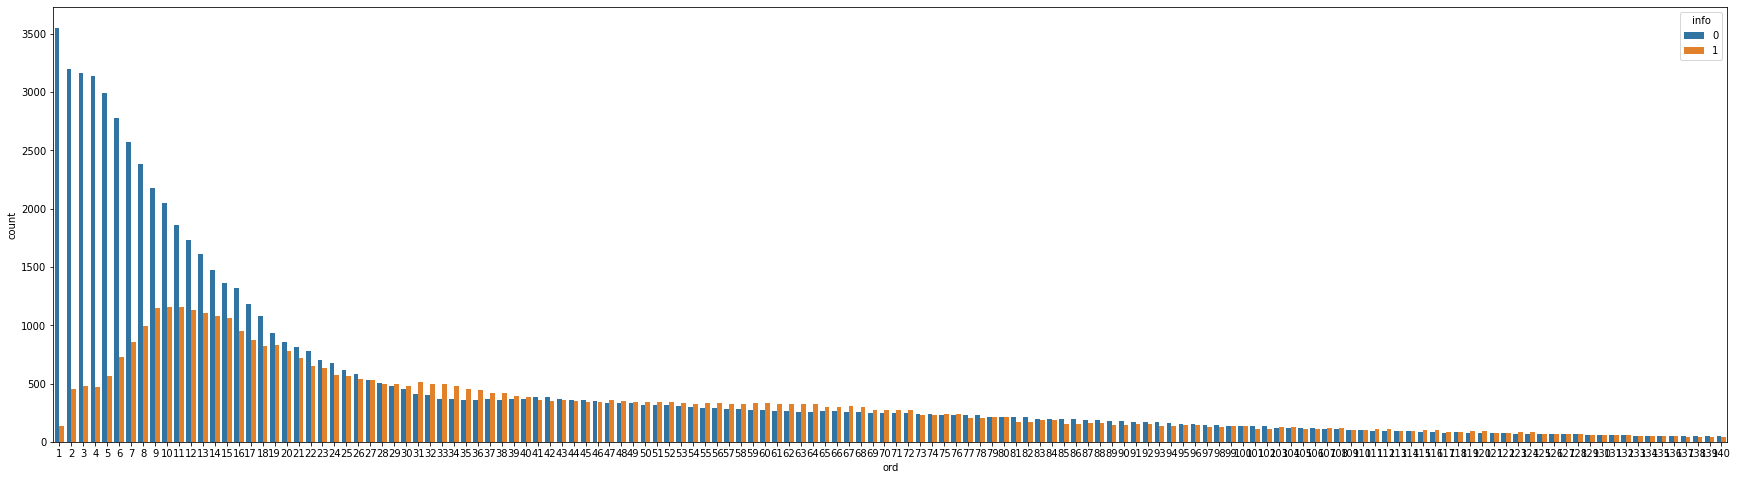

In [ ]:
plt.figure(figsize=(30,8))
sns.countplot(data = train[train['ord'] <= maximum], x='ord', hue='info')

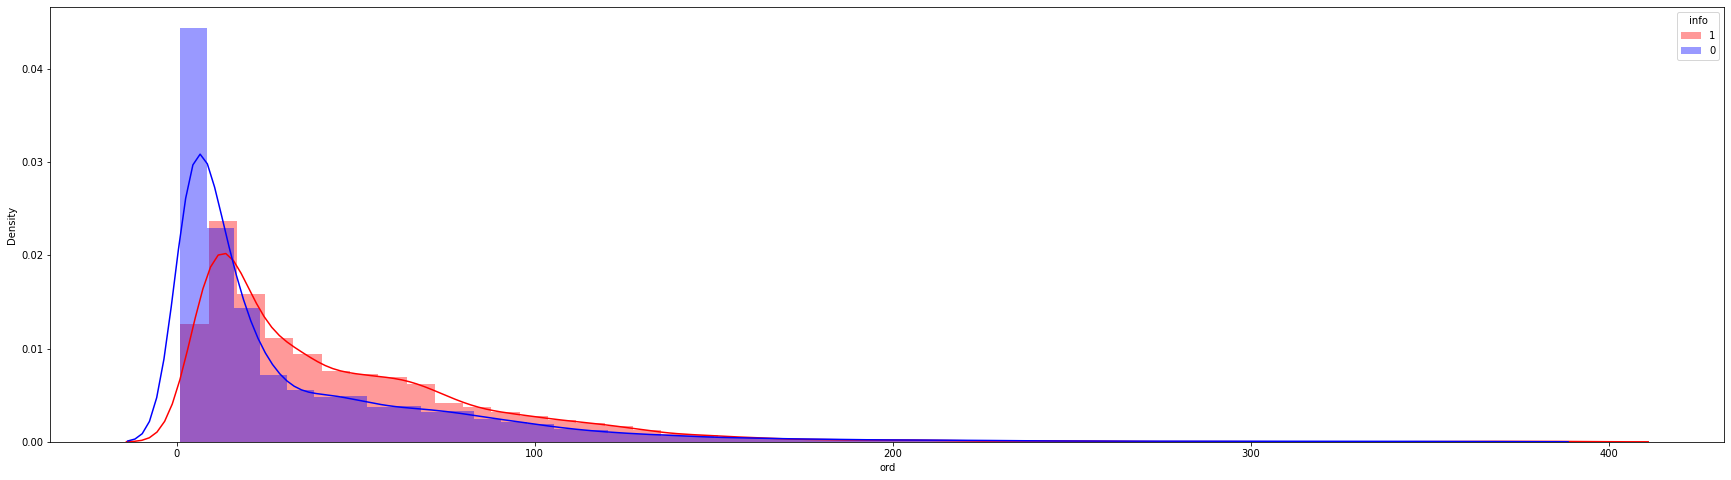

In [ ]:
plt.figure(figsize=(30,8))
sns.distplot(train[train['info'] == 1]['ord'], color='red', label='1')
sns.distplot(train[train['info'] == 0]['ord'], color='blue', label='0')
plt.legend(title='info')

## info
전체 데이터 중 약 40%가 가짜 뉴스임

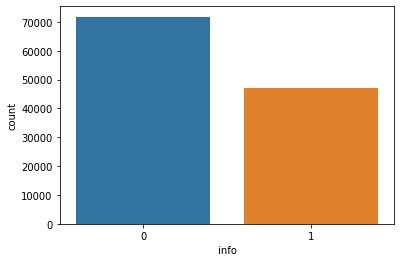

In [ ]:
sns.countplot(data = train, x='info')

In [ ]:
train['info'].sum() / train.shape[0]

0.39523348351509535

# 모델링

사용할 변수는 content, ord로 확정
1. content의 경우 진짜 뉴스와 가짜 뉴스의 텍스트가 완전히 다르기 때문에 이를 활용해서 one-hot-encoding을 한다면 예측에 좋은 영향을 줄 듯 하지만 일반화의 오류가 발생할 가능성이 매우 높아짐
2. content의 길이가 짧을 수록 가짜 뉴스일 확률이 높아지기 때문에 범위를 one-hot-encoding 또는 길이 그 자체를 활용 하지만 길이 자체가 매우 길기 때문에 범위를 범주화 하는 방법이 더 나을 수도 있다고 생각함
3. ord의 경우 8 이하라며 진짜 뉴스일 확률이 높기 때문에 이를 one-hot-encoding하여 모델에 반영한다면 좋을 결과를 줄 듯

In [ ]:
# 가짜 뉴스의 목록 
fake_content = train[train['info'] == 1]['content'].unique()

# contnet의 one-hot-encoding
train['fake_content'] = train['content'].apply(lambda x : x in fake_content)
test['fake_content'] = test['content'].apply(lambda x : x in fake_content)

In [ ]:
train['content_len'] = train['content'].apply(lambda x : len(x))
test['content_len'] = test['content'].apply(lambda x : len(x))

# contnet의 one-hot-encoding
train['fake_content_len'] = train['content_len'] <= 60
test['fake_content_len'] = test['content_len'] <= 60

In [ ]:
# ord의 one-hot-encoding
train['small_ord'] = train['ord'] <= 8
test['small_ord'] = test['ord'] <= 8

In [ ]:
# ord 정규화 Normalization
train['normal_ord'] = (train['ord'] - train['ord'].min()) / (train['ord'].max() - train['ord'].min())
test['normal_ord'] = (test['ord'] - test['ord'].min()) / (test['ord'].max() - test['ord'].min())

In [ ]:
# content_len 정규화 Normalization
train['normal_content_len'] = (train['content_len'] - train['content_len'].min()) / (train['content_len'].max() - train['content_len'].min())
test['normal_content_len'] = (test['content_len'] - test['content_len'].min()) / (test['content_len'].max() - test['content_len'].min())

모델링 전 마지막 데이터 확인

In [ ]:
train.corr()

,ord,info,date_year,date_month,date_day,title_len,content_len,fake_content,fake_content_len,small_ord,normal_ord,normal_content_len
ord,1.000000,0.124056,NaN,0.014259,-0.024831,-0.001719,-0.079034,0.123719,0.065209,-0.431602,1.000000,-0.079034
info,0.124056,1.000000,NaN,0.027979,0.013571,-0.066305,-0.351921,0.999507,0.400922,-0.264925,0.124056,-0.351921
date_year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
date_month,0.014259,0.027979,NaN,1.000000,0.045536,-0.030202,-0.008123,0.028499,0.005415,-0.013410,0.014259,-0.008123
date_day,-0.024831,0.013571,NaN,0.045536,1.000000,0.007686,0.001548,0.013578,-0.004755,0.004734,-0.024831,0.001548
title_len,-0.001719,-0.066305,NaN,-0.030202,0.007686,1.000000,0.046835,-0.066286,-0.047539,0.011753,-0.001719,0.046835
content_len,-0.079034,-0.351921,NaN,-0.008123,0.001548,0.046835,1.000000,-0.352336,-0.702157,0.143326,-0.079034,1.000000
fake_content,0.123719,0.999507,NaN,0.028499,0.013578,-0.066286,-0.352336,1.000000,0.401192,-0.264281,0.123719,-0.352336
fake_content_len,0.065209,0.400922,NaN,0.005415,-0.004755,-0.047539,-0.702157,0.401192,1.000000,-0.137019,0.065209,-0.702157
small_ord,-0.431602,-0.264925,NaN,-0.013410,0.004734,0.011753,0.143326,-0.264281,-0.137019,1.000000,-0.431602,0.143326


In [ ]:
df_cor= train.corr()
df_cor.style.background_gradient(cmap='coolwarm').set_precision(3)

,ord,info,date_year,date_month,date_day,title_len,content_len,fake_content,fake_content_len,small_ord,normal_ord,normal_content_len
ord,1.000,0.124,nan,0.014,-0.025,-0.002,-0.079,0.124,0.065,-0.432,1.000,-0.079
info,0.124,1.000,nan,0.028,0.014,-0.066,-0.352,1.000,0.401,-0.265,0.124,-0.352
date_year,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
date_month,0.014,0.028,nan,1.000,0.046,-0.030,-0.008,0.028,0.005,-0.013,0.014,-0.008
date_day,-0.025,0.014,nan,0.046,1.000,0.008,0.002,0.014,-0.005,0.005,-0.025,0.002
title_len,-0.002,-0.066,nan,-0.030,0.008,1.000,0.047,-0.066,-0.048,0.012,-0.002,0.047
content_len,-0.079,-0.352,nan,-0.008,0.002,0.047,1.000,-0.352,-0.702,0.143,-0.079,1.000
fake_content,0.124,1.000,nan,0.028,0.014,-0.066,-0.352,1.000,0.401,-0.264,0.124,-0.352
fake_content_len,0.065,0.401,nan,0.005,-0.005,-0.048,-0.702,0.401,1.000,-0.137,0.065,-0.702
small_ord,-0.432,-0.265,nan,-0.013,0.005,0.012,0.143,-0.264,-0.137,1.000,-0.432,0.143


## 자연어 처리를 사용하지 않은 모델

In [ ]:
# 사용 변수
features = ['fake_content', 'small_ord', 'fake_content_len', 'normal_ord', 'normal_content_len'] 
target = 'info'

# 데이터셋 만들기
x_train = train[features].values
y_train = train[target].values

x_test = test[features].values

# 실수로 변환
x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')

In [ ]:
batch_size = 64
input_dim = x_train.shape[1]
epochs = 5

In [ ]:
# 모델 만들기
from keras.models import Sequential
from keras import layers

model = Sequential()
model.add(layers.Dense(32, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
            optimizer='rmsprop', 
            metrics=['accuracy'])
model.summary()

model.fit(x_train, y_train,
          validation_split=0.2,
          epochs = epochs,
          verbose = True,
          batch_size = batch_size)

## 자연어 처리와 수치형 변수를 활용한 멀티플 모델

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english',lowercase=False)
vectorizer.fit(train['new_content'].values)

target = 'info'

X_train = vectorizer.transform(train['new_content'].values)
Y_train = train[target].values

X_test = vectorizer.transform(test['new_content'].values)

# 실수로 변환
X_train = X_train.astype('float64')
Y_train = Y_train.astype('float64')
X_test = X_test.astype('float64')

In [ ]:
features = ['fake_content_len', 'normal_content_len']

# 데이터셋 만들기
x_train = train[features].values

x_test = test[features].values

# 실수로 변환
x_train = x_train.astype('float64')

x_test = x_test.astype('float64')

In [ ]:
from sklearn.model_selection import train_test_split
sentences_train, sentences_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=2020)

In [ ]:
batch_size = 32
X_input_dim = X_train.shape[1]
x_input_dim = x_train.shape[1]
epochs = 30

In [ ]:
from keras.models import Sequential
from keras import models, layers


# 문자용
model1 = Sequential()
model1.add(layers.Dense(32, input_dim=X_input_dim, activation='relu'))

# 숫자용
model2 = Sequential()
model2.add(layers.Dense(32, input_dim=x_input_dim, activation='relu'))

# 출력용
model3 = layers.concatenate([model1.output, model2.output])
model3 = layers.Dense(16, activation='relu')(model3)
model3 = layers.Dense(1, activation='sigmoid')(model3)

model = models.Model([model1.input, model2.input], model3)

model.compile(loss='binary_crossentropy', 
            optimizer='rmsprop', 
            metrics=['accuracy'])
model.summary()

model.fit([X_train, x_train], Y_train,
          epochs = epochs,
          verbose = True,
          batch_size = batch_size)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_27_input (InputLayer)     [(None, 25723)]      0                                            
__________________________________________________________________________________________________
dense_28_input (InputLayer)     [(None, 2)]          0                                            
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 32)           823168      dense_27_input[0][0]             
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 32)           96          dense_28_input[0][0]             
____________________________________________________________________________________________

# 예측

In [ ]:
submission['info'] = model.predict([X_test, x_test])

In [ ]:
submission

,id,info
0,NEWS00237_1,7.147475e-05
1,NEWS00237_2,3.736152e-11
2,NEWS00237_3,3.836242e-09
3,NEWS00237_4,1.622219e-03
4,NEWS00237_5,2.375173e-07
...,...,...
142560,NEWS09482_72,1.000000e+00
142561,NEWS09482_73,1.000000e+00
142562,NEWS09482_74,1.000000e+00
142563,NEWS09482_75,1.000000e+00


In [ ]:
submission.loc[(submission['info'] >= 0.5),'info'] = 1
submission.loc[(submission['info'] < 0.5),'info'] = 0

In [ ]:
submission

,id,info
0,NEWS00237_1,0.0
1,NEWS00237_2,0.0
2,NEWS00237_3,0.0
3,NEWS00237_4,0.0
4,NEWS00237_5,0.0
...,...,...
142560,NEWS09482_72,1.0
142561,NEWS09482_73,1.0
142562,NEWS09482_74,1.0
142563,NEWS09482_75,1.0


In [ ]:
submission.to_csv("submission.csv", index=False)

# 결과
- 자연어 처리를 하지 않은 모델의 경우 베이스라인과 동일한 점수
- 간단한 자연어 처리 후 추출한 명사만을 활용하면 만든 멀티플 모델은 자연어 처리를 하지 않은 모델보다 조금 더 높은 성능을 보여줌  
- 따라서 현재 중요한 feature은 content로 판단됨
- content 변수의 특징을 모델에 더 잘 반영할 수 있도록 다양한 텍스트 마이닝의 접근법을 통해서 EDA를 시행하는 것이 앞으로 model의 정확도를 높이는데에 더 큰 도움이 될 것임